In [86]:
import os
import sys

import pandas as pd

sys.path.append('../')
import torch
import matplotlib.pyplot as plt

from src.utils import transforms_testing, ImageNetDataset
from torch.utils.data import DataLoader

from transformers import AutoModel, AutoConfig
from hf_pretrained_model import ResVQVAEResNet50Config, ResVQVAEResNet50

In [2]:
img_size = 224
path_to_data = '../data'

In [3]:
transforms_test = transforms_testing(img_wh=img_size)

test_data = ImageNetDataset(os.path.join(path_to_data, 'test'),
                            transform=transforms_test)

n = 10
testloader = DataLoader(test_data,
                        shuffle=True,
                        num_workers=5,
                        batch_size=n)

test_loader_iterable = iter(testloader)

In [33]:
# Register model
AutoConfig.register('res-vqvae-net50', ResVQVAEResNet50Config)
AutoModel.register(ResVQVAEResNet50Config, ResVQVAEResNet50)

# Load the model
model = AutoModel.from_pretrained('detker/res-vqvae-net50-48M',
                                  trust_remote_code=True)
model.train()

ResVQVAEResNet50(
  (model): ConvResidualVQVAE(
    (encoder): ResEncoder(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (layer0): Sequential(
        (0): EncResidualBlock(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (relu): ReLU()
          (downsample): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): EncResidualBlock(
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [337]:
def generate_plots(recon, img, ax, n=10):
    for i in range(0, n):
        ax[0,i].imshow(img[i].permute(1,2,0))
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[1,i].imshow(recon[i].permute(1,2,0))
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
    plt.show() 

torch.Size([10, 2048, 14, 14])
torch.Size([10, 3, 224, 224])


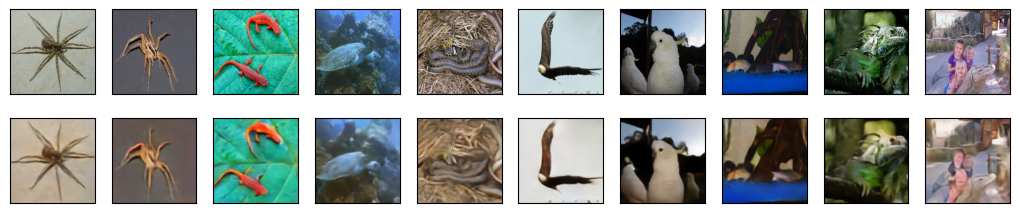

torch.Size([10, 2048, 14, 14])
torch.Size([10, 3, 224, 224])


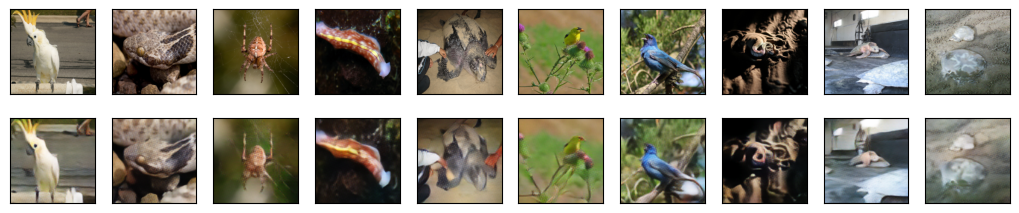

torch.Size([10, 2048, 14, 14])
torch.Size([10, 3, 224, 224])


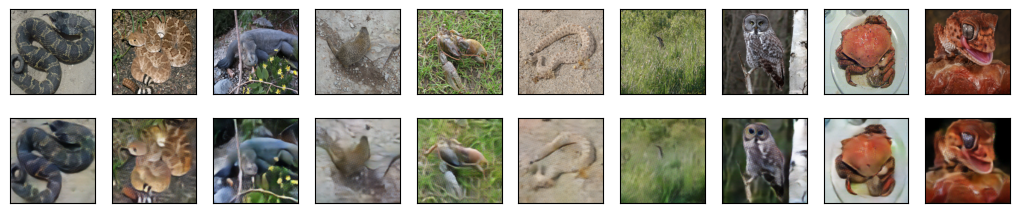

torch.Size([10, 2048, 14, 14])
torch.Size([10, 3, 224, 224])


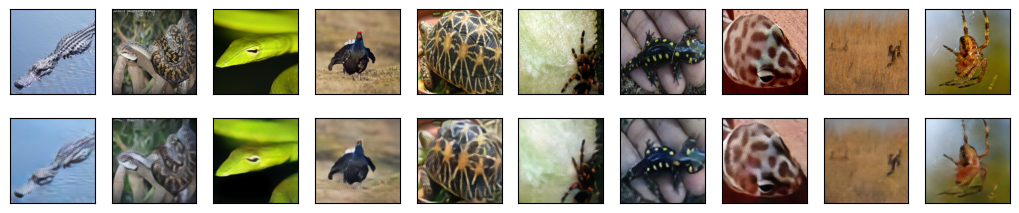

torch.Size([10, 2048, 14, 14])
torch.Size([10, 3, 224, 224])


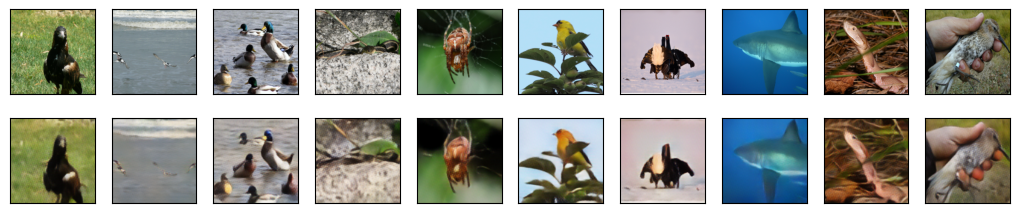

In [338]:
for _ in range(5):
    data = next(test_loader_iterable)
    img, lbl = data
    with torch.no_grad():
        latent, quantized_latent, dec, codebook_loss, commitment_loss, codebooks_usage_ratios, codebooks_perplexities = model(img)

    fig, ax = plt.subplots(2, 10, figsize=(10,2))
    fig.subplots_adjust(0,0,1,1)
    generate_plots(dec, img, ax, n=n)


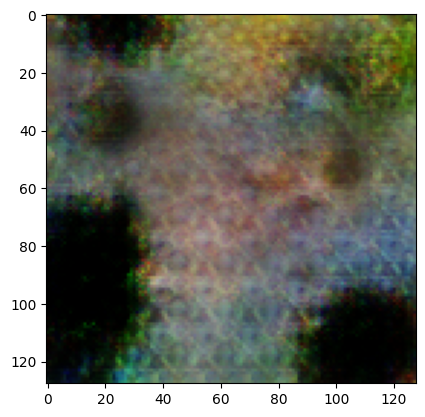

In [346]:

x = torch.randn(size=(1,2048,8,8))
with torch.no_grad():
    dec2, quantized_latent, codebook_loss, commitment_loss, codebooks_usage_ratios, codebooks_perplexities = model.dec_forward(x)

dec2 = dec2.squeeze(0).permute(1,2,0)
plt.imshow(dec2)
plt.show()

In [347]:
def quantize(z):
    batch_size, latent_dim, h, w = z.shape
    z = z.permute(0, 2, 3, 1).contiguous().reshape(-1, latent_dim)  # (B*H'*W', latent_dim)
    quantized_z, codebook_loss, commitment_loss, codebooks_usage_ratios, codebooks_perplexities = model.quantize(z)
    quantized_z = quantized_z.reshape(batch_size, h, w, latent_dim).permute(0, 3, 1, 2).contiguous()  # (B, latent_dim, H', W')
    return quantized_z


In [348]:
def generate_plots2(recon, ax, n=10):
    for i in range(0, n):
        ax[i].imshow(recon[i].permute(1,2,0))
        ax[i].axis('off')
    plt.show() 


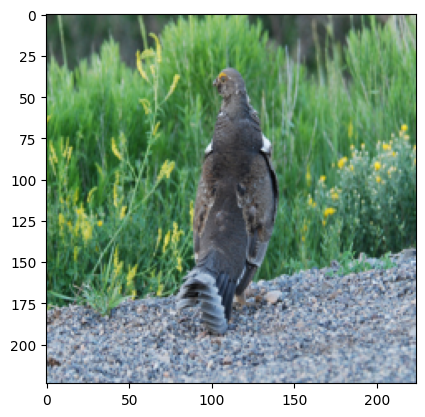

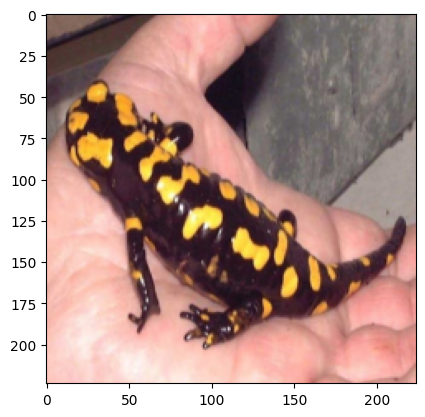

torch.Size([1, 2048, 14, 14])
torch.Size([1, 2048, 14, 14])


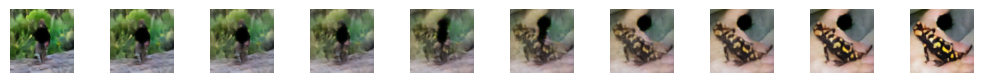

In [358]:
imgs, lbls = next(test_loader_iterable)
img1, img2 = imgs[0], imgs[1]
plt.imshow(img1.permute(1,2,0))
plt.show()
plt.imshow(img2.permute(1,2,0))
plt.show()
with torch.no_grad():
    enc1 = model.enc_forward(img1.unsqueeze(0))
    enc2 = model.enc_forward(img2.unsqueeze(0))
    quantized1 = quantize(enc1)
    quantized2 = quantize(enc2)
    alpha = torch.linspace(0,1,steps=10).reshape(-1,1,1,1) # 10 intermediate frames
    dec_in = (1-alpha)*quantized1 + alpha*quantized2
    dec = model.decoder(dec_in)
    fig, ax = plt.subplots(1, 10, figsize=(10,1))
    fig.tight_layout(pad=0)
    generate_plots2(dec, ax, n=n)
    plt.show()
    

In [34]:
import cv2

def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR) 
    if img is None:
        raise ValueError(f"Could not read image {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = transforms_test(img)
    
    return img

In [61]:
img = load_img('../imgs/man.jpeg').unsqueeze(0)

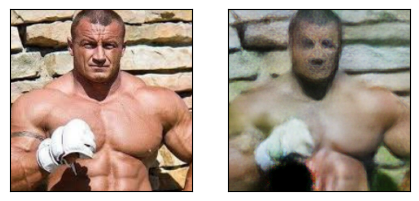

In [62]:
with torch.no_grad():
    latent, quantized_latent, dec, codebook_loss, commitment_loss, codebooks_usage_ratios, codebooks_perplexities = model(img)
fig, ax = plt.subplots(1, 2, figsize=(4,2))
fig.subplots_adjust(0,0,1,1)
ax[0].imshow(img.squeeze(0).permute(1,2,0))
ax[1].imshow(dec.squeeze(0).permute(1,2,0))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [318]:
from PIL import Image

frames = []
steps = 30 
max_scale = 10.0
noise = torch.randn(size=(1,2048,14,14))

for i in range(steps):
    scale = i / (steps-1) * max_scale
    with torch.no_grad():
        latent = model.enc_forward(img)    
        z = latent + scale * noise
        dec_enchanced, quantized_z, codebook_loss, commitment_loss, codebooks_usage_ratios, codebooks_perplexiti = model.dec_forward(z)
    dec_enchanced = dec_enchanced[0].detach().cpu()
    dec_enchanced = (dec_enchanced.clamp(0,1).permute(1,2,0).numpy() * 255).astype("uint8")
    frames.append(Image.fromarray(dec_enchanced))

frames[0].save(
    "zaszumiony_mezczyzna.gif",
    save_all=True,
    append_images=frames[1:]+frames[::-1],
    duration=60,
    loop=0
)